# Fit an image model to some ALMA uv data
This example uses some heavily averaged data (to keep the file small) to illustrate how to use this package to model some uv data. The data can be exported from the .ms file using uvplot, and the fit metric here is computed using galario. Both can be found here: https://github.com/mtazzari/

In [1]:
import numpy as np
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
import galario.double as gd
from galario import arcsec

import alma.image

%matplotlib notebook

In [2]:
# import the data
u, v, Re, Im, w = np.require( np.loadtxt("hr4796-uv-spw0-w32-t20s.txt", unpack=True),
                             requirements=["C_CONTIGUOUS"])

wle = 862e-6  # [m] from the header of the uv file
u /= wle
v /= wle

# re-weight so that chi^2 for null model is 1
w /= np.sum( ( Re**2.0 + Im**2.0) * w ) / len(w)

In [9]:
# set image properties, can cut dxy down for speed (at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True)
dxy_arcsec = dxy / arcsec

xc = (nxy-1)/2.
x = np.arange(nxy)-xc
xx,yy = np.meshgrid(x,x)

dxy:1.762605e-02arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:7.219631e+00arcsec


In [10]:
# make the image object
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy), dens_model='gauss_3d', z_fact=1)

model:los_image_axisym with density:gauss_3d and emit:blackbody
parameters are ['x_0', 'y_0', '$\\Omega$', '$i$', 'F', '$r_0$', '$\\sigma_r$', '$\\sigma_h$']
rmax not set, run compute_rmax or image generation may fail or take a while your image is large


In [11]:
# parameters, got somehow...
p0 = [0.02, 0.02, 26.0, 76, 0.015, 1., 0.04, 0.01]

# parameter space domain
p_ranges = [[-0.1, 0.1],
            [-0.1, 0.1],
            [-180,  180],
            [0.,  90],
            [0.,  1.],
            [0., 2.],
            [0.0, 1.],
            [0.0, 1.]]

radial r_max: 82 pix
model x,y,z extent 19, 74, 72
183 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


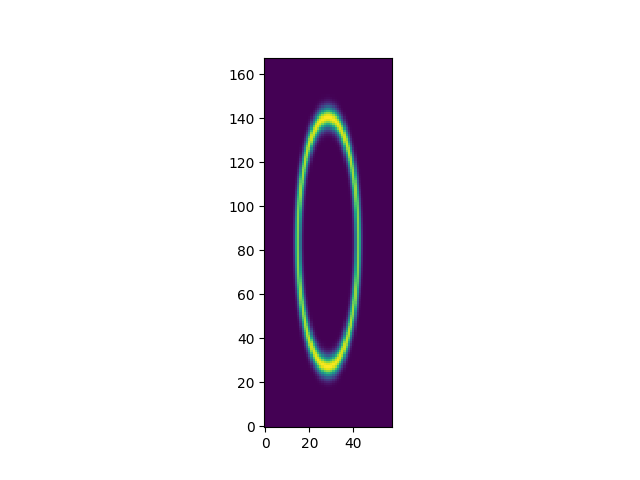

In [12]:
# set rmax based on these params
ii.compute_rmax(p0)

# this gives an idea of how long an mcmc might take
%timeit ii.image_full(p0)

im = ii.image(p0[3:])
fig,ax = plt.subplots()
ax.imshow(im[ii.cc], origin='bottom')

In [7]:
def lnpostfn(p):
    """ Log of posterior probability function """

    for i in range(len(p)):
        if p[i] < p_ranges[i][0] or p[i] > p_ranges[i][1]:
            return -np.inf

    # we generate the image with PA = North
    image = ii.image(p[3:])
    
    # galario  translates and rotates it for us
    chi2 = gd.chi2Image(image, dxy, u, v, Re, Im, w,
                        dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )
    return -0.5 * chi2

nlnpostfn = lambda p: -lnpostfn(p)

In [ ]:
# get a best fit to estimate mcmc starting params
res = scipy.optimize.minimize(nlnpostfn, p0, method='Nelder-Mead')
print(res['x'])
p0 = np.array(res['x'])

# show the image, before translation and rotation
im = ii.image(p0[3:])
fig,ax = plt.subplots()
ax.imshow(im[ii.cc],origin='bottom')

[  1.91884156e-02   1.75458639e-02   2.64266394e+01   7.62044618e+01
   1.54051765e-02   1.07851729e+00   4.17336212e-02   4.13455405e-02]


<IPython.core.display.Javascript object>

In [ ]:
ndim = len(p_ranges)        # number of dimensions
nwalkers = 16               # number of walkers
nsteps = 1000               # total number of MCMC steps
nthreads = 8                # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

In [ ]:
burn = 200
fig,ax = plt.subplots(ndim+1,figsize=(9.5,5),sharex=True)
for j in range(nwalkers):
    ax[-1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i].plot(sampler.chain[j,burn:,i])
        ax[i].set_ylabel(ii.params[i])
        
fig.savefig('chains.png')

In [ ]:
# plot the resulting MCMC
fig = corner.corner(sampler.chain[:,burn:,:].reshape((-1,ndim)), labels=ii.params,
                    show_titles=True)

fig.savefig('corner.png')

In [ ]:
# get the median parameters
# p = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
# s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
# print(p)
# print(s)
p=p0

# recompute the limits for the full rotated image
ii.compute_rmax(p, image_full=True)

fig,ax = plt.subplots()
ax.imshow(ii.image_full(p)[ii.cc], origin='bottom')
fig.savefig('best_img.png')